# Evaluation metrics for classification models

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.mode.chained_assignment = None
%matplotlib inline

### Back with the credit card default dataset

In [40]:
# Loading the dataset
DATA_DIR = '../data'
FILE_NAME = 'credit_card_default.csv'
data_path = os.path.join(DATA_DIR, FILE_NAME)
ccd = pd.read_csv(data_path, index_col="ID")
ccd.rename(columns=lambda x: x.lower(), inplace=True)
ccd.rename(columns={'default payment next month':'default'}, inplace=True)

# getting the groups of features
bill_amt_features = ['bill_amt'+ str(i) for i in range(1,7)]
pay_amt_features = ['pay_amt'+ str(i) for i in range(1,7)]
numerical_features = ['limit_bal','age'] + bill_amt_features + pay_amt_features

# Creating creating binary features
ccd['male'] = (ccd['sex'] == 1).astype('int')
ccd['grad_school'] = (ccd['education'] == 1).astype('int')
ccd['university'] = (ccd['education'] == 2).astype('int')
ccd['married'] = (ccd['marriage'] == 1).astype('int')

# simplifying pay features 
pay_features= ['pay_' + str(i) for i in range(1,7)]
for x in pay_features:
    ccd.loc[ccd[x] <= 0, x] = 0

# simplifying delayed features
delayed_features = ['delayed_' + str(i) for i in range(1,7)]
for pay, delayed in zip(pay_features, delayed_features):
    ccd[delayed] = (ccd[pay] > 0).astype(int)
    
# creating a new feature: months delayed
ccd['months_delayed'] = ccd[delayed_features].sum(axis=1)

## Splitting  and standarizing the dataset

In [41]:
numerical_features = numerical_features + ['months_delayed']
binary_features = ['male','married','grad_school','university']
X = ccd[numerical_features + binary_features]
y = ccd['default'].astype(int)

## Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5/30, random_state=25)

## Standarize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train.loc[:, numerical_features] = scaler.transform(X_train[numerical_features])
# Standarize also the testing set
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

## Performance metrics

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=25,
                            max_features=6,
                            max_depth=4,
                            random_state=61)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=61, verbose=0, warm_start=False)

In [43]:
from sklearn.metrics import confusion_matrix
def CM(y_true, y_pred):
    M = confusion_matrix(y_true, y_pred)
    out = pd.DataFrame(M, index=["Obs Paid", "Obs Default"], columns=["Pred Paid", "Pred Default"])
    return out

In [44]:
threshold = 0.5
y_pred_prob = rf.predict_proba(X_test)[:,1]
y_pred = (y_pred_prob > threshold).astype(int)

In [45]:
CM(y_test, y_pred)

,Pred Paid,Pred Default
Obs Paid,3746,133
Obs Default,852,269


In [46]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision: {:0.1f}%, Recall: {:.1f}%, Accuracy: {:0.1f}%".format(100*precision, 100*recall, 100*accuracy))

Precision: 66.9%, Recall: 24.0%, Accuracy: 80.3%


## Visualization methods for evaluating classification models

### Visualizing probabilities

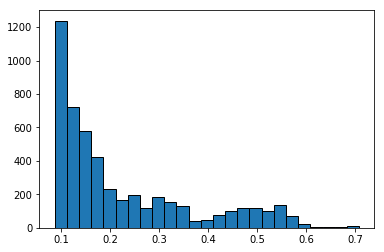

In [47]:
plt.hist(y_pred_prob, bins=25, ec='k');

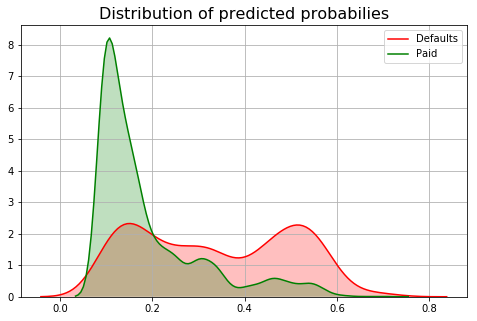

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
sns.kdeplot(y_pred_prob[y_test==1], shade=True, color='red', label="Defaults", ax=ax)
sns.kdeplot(y_pred_prob[y_test==0], shade=True, color='green', label="Paid", ax=ax)
ax.set_title("Distribution of predicted probabilies", fontsize=16)
ax.legend()
plt.grid();

### ROC and precision-recall curves

In [49]:
threshold = 0.4
y_pred_prob = rf.predict_proba(X_test)[:,1]
y_pred = (y_pred_prob > threshold).astype(int)
CM(y_test, y_pred)

,Pred Paid,Pred Default
Obs Paid,3556,323
Obs Default,654,467


In [50]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision: {:0.1f}%, Recall: {:.1f}%, Accuracy: {:0.1f}%".format(100*precision, 100*recall, 100*accuracy))

Precision: 59.1%, Recall: 41.7%, Accuracy: 80.5%


In [52]:
from sklearn.metrics import precision_recall_curve
precs, recs, ths = precision_recall_curve(y_test, y_pred_prob)

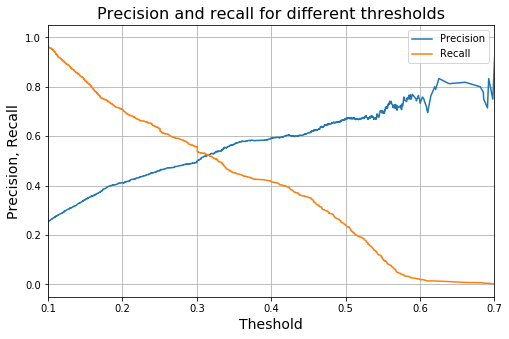

In [62]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ths, precs[1:], label='Precision')
ax.plot(ths, recs[1:], label='Recall')
ax.set_title('Precision and recall for different thresholds', fontsize=16)
ax.set_xlabel('Theshold', fontsize=14)
ax.set_ylabel('Precision, Recall', fontsize=14)
ax.set_xlim(0.1,0.7)
ax.legend(); ax.grid();

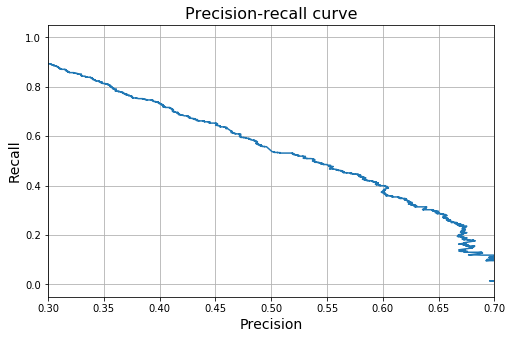

In [63]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precs, recs)
ax.set_title('Precision-recall curve', fontsize=16)
ax.set_xlabel('Precision', fontsize=14)
ax.set_ylabel('Recall', fontsize=14)
ax.set_xlim(0.3,0.7)
ax.grid();

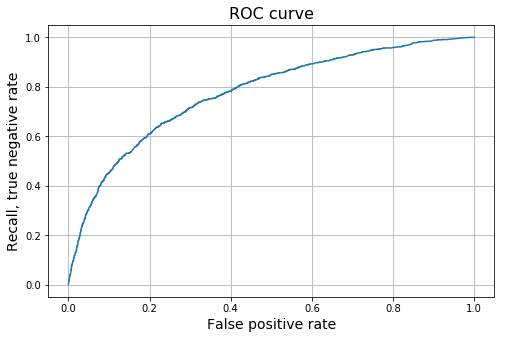

In [76]:
from sklearn.metrics import roc_curve
fpr, tpr, ths = roc_curve(y_test, y_pred_prob)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr)
ax.set_title('ROC curve', fontsize=16)
ax.set_xlabel('False positive rate', fontsize=14)
ax.set_ylabel('Recall, true negative rate', fontsize=14)
ax.grid();

### Defining a custom metric for classification

In [69]:
def class_cost(y_true, y_pred, cost_fn=1, cost_fp=1):
    M = confusion_matrix(y_true, y_pred)
    N = len(y_true)
    FN = M[1,0]
    FP = M[0,1]
    return (cost_fn*FN + cost_fp*FP)/N

In [70]:
class_cost(y_test, y_pred)

0.1954

In [71]:
thresholds = np.arange(0.05, 0.95, 0.01)
costs = []
for th in thresholds:
    y_pred = (y_pred_prob > th).astype(int)
    costs.append(class_cost(y_test, y_pred, cost_fn=3, cost_fp=1))
    
costs = np.array(costs)

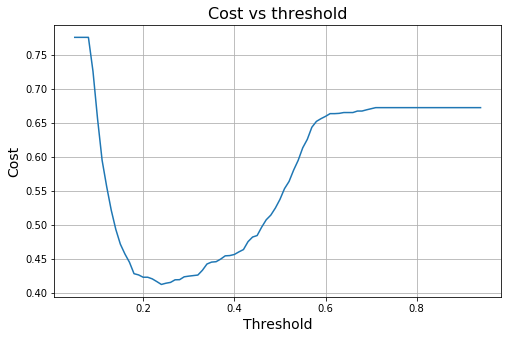

In [73]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds, costs)
ax.set_title('Cost vs threshold', fontsize=16)
ax.set_xlabel('Threshold', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)
ax.grid();

In [74]:
min_cost_th = thresholds[costs.argmin()]
min_cost_th

0.24000000000000005

In [75]:
y_pred = (y_pred_prob > min_cost_th).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precision: {:0.1f}%, Recall: {:.1f}%".format(100*precision, 100*recall))
CM(y_test, y_pred)

Precision: 45.2%, Recall: 64.9%


,Pred Paid,Pred Default
Obs Paid,2996,883
Obs Default,394,727
